In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2  
import keras 
from keras import models, layers 
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split

In [2]:
import glob 

# Get the video

In [ ]:
snippet = cv2.VideoCapture('VideoSnippet/carv2.mp4')
snippet.set(cv2.CAP_PROP_FPS, 60) 

In [ ]:
cascadeAlgorithm = cv2.CascadeClassifier('classfierCascadeCar.xml')

# Car Detection

In [ ]:
while True:
    ret, frames = snippet.read()
    #gray = cv2.cvtColor(frames, cv2.COLOR_BGR2GRAY)
    
    # Applying algorith to detect cars, using B&W filter with 1.1 as ScaleFactor and 9 neighbors minimum
    cars = cascadeAlgorithm.detectMultiScale(frames, 1.05, 13)

    # Drawing rectangle to around cars
    for(coord_x, coord_y, width, height) in cars:
        cv2.rectangle(frames, (coord_x, coord_y), (coord_x+width, coord_y+height), color=(0, 0, 255), thickness=2)
        cv2.putText(frames, 'Car', (coord_x, coord_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    cv2.imshow('Car Detection System', frames)

# Car Recognition Algorythm

NB : JPG File came from this [link](https://drive.google.com/file/d/1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD/view) which represent the [Dataset](https://github.com/nicolas-gervais/predicting-car-price-from-scraped-data/tree/master/picture-scraper) to get the brand of the car scanned

In [3]:
images = glob.glob('*.jpg')

data = pd.DataFrame(images, columns=['src'])

In [4]:
data['brand'] = data['src'].apply(lambda x : x.split('_')[0].split('/')[-1])

data['brand'].value_counts()

Chevrolet        5079
Toyota           4598
Ford             4416
BMW              4121
Nissan           3881
Audi             3131
Mercedes-Benz    3097
Honda            2675
Kia              2160
Lexus            2125
Hyundai          2091
GMC              2067
Volkswagen       1752
Subaru           1605
Mazda            1475
Dodge            1345
Porsche          1344
Lincoln          1324
Cadillac         1311
Volvo            1231
Jeep             1196
Acura            1174
Jaguar           1062
MINI             1059
Buick             964
Land Rover        960
INFINITI          917
FIAT              892
Ram               747
Bentley           697
Mitsubishi        644
Aston Martin      574
Chrysler          570
Maserati          449
smart             386
Alfa Romeo        290
Rolls-Royce       277
Lamborghini       251
Tesla             191
Genesis           176
Ferrari            91
McLaren            72
Name: brand, dtype: int64

In [5]:
data = data[(data['brand']=='Chevrolet') |(data['brand']=='Toyota')|(data['brand']=='Ford') |(data['brand']=='Nissan')  |(data['brand']=='Volkswagen')].reset_index(drop=True)
data['brand'].value_counts()

Chevrolet     5079
Toyota        4598
Ford          4416
Nissan        3881
Volkswagen    1752
Name: brand, dtype: int64

# Data Exploration

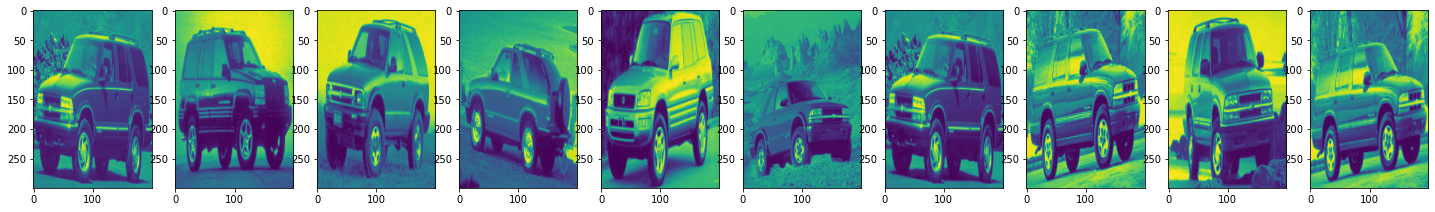

In [6]:
X= []
y= []
for i in range(len(data)):
    src = data.loc[i,'src']
    src = cv2.imread(src, cv2.IMREAD_COLOR)
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    X.append(cv2.resize(dst, dsize=(200, 300), interpolation=cv2.INTER_AREA))
    y.append(data.loc[i,'brand'])
    
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(X[i])

In [7]:
set(y)

{'Chevrolet', 'Ford', 'Nissan', 'Toyota', 'Volkswagen'}

In [8]:
X = np.array(X)
X = X.astype('float32')
X = X /255.0
X = X.reshape(-1,300,200,1)
y= np.array(pd.get_dummies(pd.DataFrame(y),columns=[0])) # Resultat classification entrainement

X.shape, y.shape

((19726, 300, 200, 1), (19726, 5))

# Training model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13808, 300, 200, 1), (5918, 300, 200, 1), (13808, 5), (5918, 5))

In [ ]:
input_shape = X_train.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = "softmax"))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = 256, epochs = 12, shuffle=True, validation_data=(X_test,y_test),verbose = 0)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
fig,axes = plt.subplots(1,2, figsize=(15,8))
fig.suptitle("The model 's evaluation ",fontsize=20)
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train','Test'])


axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train','Test'])
plt.show()